<a href="https://colab.research.google.com/github/sy-hwang/DeepLearningZeroToAll/blob/master/standalone/lab_04_cifar10_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

ERROR: Could not find a version that satisfies the requirement torch==1.0.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch==1.0.0
2.4.0+cu121


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [46]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(len(trainset), len(valset), len(testset))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


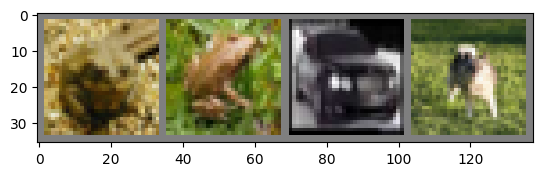

frog  frog  car   dog  


In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [48]:
print(type(images), images.shape) #batchsize =4, channnel=3, widthxheight=32x32
print(type(labels), labels.shape, labels)

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([6, 6, 1, 5])


In [49]:
import torch.nn as nn
class MLP(nn.Module):
  def __init__(self, in_dim, out_dim, hidden_dim, hidden_layer, act):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hidden_dim = hidden_dim
    self.hidden_layer = hidden_layer

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(in_dim, hidden_dim))
    for _ in range(hidden_layer-1):
      self.layers.append(nn.Linear(hidden_dim, hidden_dim))
    self.outlayer = nn.Linear(hidden_dim, out_dim)

    if(act == 'relu'):
      self.act = nn.ReLU()
    elif(act == 'sigmoid'):
      self.act = nn.Sigmoid()
    elif(act == 'tanh'):
      self.act = nn.Tanh()
    else:
      self.act = nn.ReLU()

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
      x = self.act(x)
    x = self.outlayer(x)
    return x

model = MLP(3072, 10, 100, 4, 'relu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (outlayer): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs= inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 3072)


        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.165
[1,  4000] loss: 1.897
[1,  6000] loss: 1.767
[1,  8000] loss: 1.701
[1, 10000] loss: 1.661
[2,  2000] loss: 1.600
[2,  4000] loss: 1.576
[2,  6000] loss: 1.549
[2,  8000] loss: 1.561
[2, 10000] loss: 1.532
Finished Training


In [80]:
#===========Test Accuray==============
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images= images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 3072)
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 44 %


In [55]:
#===========Val Accuray==============
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
val_loss = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images= images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 3072)
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_loss = val_loss/len(valloader)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %, loss:{val_loss}')

Accuracy of the network on the 10000 test images: 44 %, loss:1.5668964040160178


In [83]:
def experiment(args):
  model = MLP(args.in_dim, args.out_dim, args.hidden_dim, args.n_layer, args.act)
  model.to(args.device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), args.lr, args.momentum)

  for epoch in range(args.epoch):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs= inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 3072)


        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()

        #===========Val Accuray==============
    correct = 0
    total = 0
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images= images.to(device)
            labels = labels.to(device)
            images = images.view(-1, 3072)
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss/len(valloader)

    print(f'[{epoch}]trainloss:{running_loss} val Accuracy: {100 * correct // total} %, val loss:{val_loss}')

  correct = 0
  total = 0
  # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images= images.to(device)
          labels = labels.to(device)
          images = images.view(-1, 3072)
          # 신경망에 이미지를 통과시켜 출력을 계산합니다
          outputs = model(images)
          # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
  return 100 * correct // total


In [84]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hidden_dim = 100
args.act = 'relu'
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.lr = 0.001
args.batch_size = 4
args.epoch = 5
args.momentum = 0.9

print(experiment(args))

[0]trainloss:19645.225998461246 val Accuracy: 37 %, val loss:1.686545539546013
[1]trainloss:16044.64200207591 val Accuracy: 43 %, val loss:1.5954691214442254
[2]trainloss:14854.03188547492 val Accuracy: 47 %, val loss:1.488554115152359
[3]trainloss:13988.726581089199 val Accuracy: 48 %, val loss:1.4594301045179368
[4]trainloss:13338.059758469462 val Accuracy: 50 %, val loss:1.4273204376637936
Accuracy of the network on the 10000 test images: 50 %
50


In [ ]:
l